In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [3]:
df_credit = pd.read_csv("../datasets/credit_record.csv")
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764711 entries, 0 to 764710
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              764711 non-null  int64 
 1   MONTHS_BALANCE  764711 non-null  int64 
 2   STATUS          764711 non-null  object
dtypes: int64(2), object(1)
memory usage: 17.5+ MB


In [6]:
df_credit['ID'].duplicated().sum()

731301

In [7]:
df_application = pd.read_csv("../datasets/application_record.csv")
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,NaN,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,NaN,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,NaN,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [8]:
df_application["ID"].duplicated().sum()

47

In [9]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438551 non-null  float64
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [10]:
df_application.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                6
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [21]:
# Compute the mode of STATUS for each ID and remove rows where mode_status is 'X'
mode_status = df_credit.groupby('ID')['STATUS'].agg(lambda x: x.mode()[0]).reset_index()
mode_status.rename(columns={'STATUS': 'mode_status'}, inplace=True)
mode_status = mode_status[mode_status['mode_status'] != 'X']

# Merge the filtered mode_status with application_df
merged_df = pd.merge(df_application, mode_status, on='ID', how='inner')

In [22]:
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,mode_status
0,5008804,M,Y,Y,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,C
1,5008805,M,Y,Y,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,C
2,5008810,F,N,Y,NaN,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,C
3,5008811,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,C
4,5008812,F,N,Y,0.0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0


In [23]:
mode_status.head()

,ID,mode_status
0,5001711,0
1,5001712,0
5,5001717,0
6,5001718,0
7,5001719,C


In [27]:
print(mode_status['mode_status'].unique())

['0' 'C' '1' '5' '2']


In [28]:
# Define the label_status function to categorize the mode_status
def label_status(status):
    if status in ["0", "1", "2", "3", "4", "5"]:
        return 'bad'
    elif status == 'C':
        return 'good'
    else:
        return 'unknown'

In [29]:
mode_status["mode_status"].value_counts()

mode_status
0    15573
C    11957
1       70
5       33
2        2
Name: count, dtype: int64

In [30]:
# Apply the label_status function
merged_df["label"] = merged_df["mode_status"].apply(label_status)

merged_df['label'].value_counts()

label
bad     12600
good     8953
Name: count, dtype: int64

In [31]:
# Assign binary target: 0 for bad, 1 for good
merged_df["TARGET"] = merged_df["label"].apply(lambda x: 0 if x == "bad" else 1)

merged_df["TARGET"].value_counts()

TARGET
0    12600
1     8953
Name: count, dtype: int64

In [32]:
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,mode_status,label,TARGET
0,5008804,M,Y,Y,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,C,good,1
1,5008805,M,Y,Y,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,C,good,1
2,5008810,F,N,Y,NaN,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,C,good,1
3,5008811,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,C,good,1
4,5008812,F,N,Y,0.0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,365243,1,0,0,0,NaN,1.0,0,bad,0


In [33]:
merged_df.drop(columns=["mode_status", "label"], inplace=True)

In [34]:
merged_df['ID'].duplicated().sum()

0

In [35]:
merged_df.shape

(21553, 19)

In [36]:
# Handle missing values in OCCUPATION_TYPE
merged_df.fillna({'OCCUPATION_TYPE': 'Unknown'}, inplace=True)

In [38]:
occupation_types = merged_df['OCCUPATION_TYPE'].unique()
print(occupation_types)

['Unknown' 'Sales staff' 'Accountants' 'Laborers' 'Managers' 'Drivers'
 'Core staff' 'Security staff' 'High skill tech staff' 'Cleaning staff'
 'Cooking staff' 'Low-skill Laborers' 'Medicine staff'
 'Private service staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'IT staff' 'Realty agents']


In [51]:
# Compute age from DAYS_BIRTH
merged_df["AGE"] = merged_df["DAYS_BIRTH"].apply(lambda x: abs(x) // 365)

# Calculate credit history length
credit_history_length = df_credit.groupby('ID')['MONTHS_BALANCE'].agg(lambda x: x.max() - x.min()).reset_index()

Index(['ID', 'MONTHS_BALANCE'], dtype='object')

In [52]:
credit_history_length.columns = ['ID', 'CREDIT_HISTORY_LENGTH']

In [53]:
merged_df = pd.merge(merged_df, credit_history_length, on='ID', how='left')

In [54]:
# Determine if there's recent activity within the last 6 months
def recent_activity(months_balance):
    return 1 if any(month >= -6 for month in months_balance) else 0

recent_activity_flag = df_credit.groupby('ID')['MONTHS_BALANCE'].apply(recent_activity).reset_index()
recent_activity_flag.columns = ['ID', 'RECENT_ACTIVITY']
merged_df = pd.merge(merged_df, recent_activity_flag, on='ID', how='left')

In [55]:
# Calculate years employed and unemployment status
merged_df['YEARS_EMPLOYED'] = merged_df['DAYS_EMPLOYED'].apply(lambda x: abs(x) // 365.0)
merged_df['IS_UNEMPLOYED']  = merged_df['DAYS_EMPLOYED'].apply(lambda x: 1 if x > 0 else 0)

In [56]:
# Encode categorical variables
le = LabelEncoder()
merged_df['CODE_GENDER'] = le.fit_transform(merged_df['CODE_GENDER'])
merged_df['FLAG_OWN_CAR'] = le.fit_transform(merged_df['FLAG_OWN_CAR'])
merged_df['FLAG_OWN_REALTY'] = le.fit_transform(merged_df['FLAG_OWN_REALTY'])

In [57]:
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE,CREDIT_HISTORY_LENGTH,RECENT_ACTIVITY,YEARS_EMPLOYED,IS_UNEMPLOYED
0,5008804,1,1,1,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,Unknown,2.0,1,32,15,1,12.0,0
1,5008805,1,1,1,NaN,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,Unknown,2.0,1,32,14,1,12.0,0
2,5008810,0,0,1,NaN,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,1,52,26,1,8.0,0
3,5008811,0,0,1,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,1,52,38,1,8.0,0
4,5008812,0,0,1,0.0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,0,0,Unknown,1.0,0,61,16,1,1000.0,1


In [62]:
cat_col = [col for col in merged_df.columns if merged_df[col].dtype in ['category', 'object'] and col != 'OCCUPATION_TYPE']
cat_col

['NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [63]:
def categorical_columns_analysis(df, col, plot=False):
    """
    Function to analyze categorical columns in a DataFrame.

    Parameters:
    df : DataFrame
        DataFrame whose categorical columns will be analyzed.
    col : str
        Name of the column to be analyzed.
    plot : bool, optional
        If True, a countplot will be generated for the column. Default is False.

    Returns:
    None
    """
    print(f"Analysis for column: {col}")
    print(f"Number of unique values: {df[col].nunique()}")
    print(f"Unique values are: {df[col].unique()}")
    print(f"Value counts:\n{df[col].value_counts()}")
    
    if plot:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, palette="viridis")
        plt.title(f"Countplot for {col}")
        plt.xticks(rotation=45)
        plt.show()

Analysis for column: NAME_INCOME_TYPE
Number of unique values: 5
Unique values are: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
Value counts:
NAME_INCOME_TYPE
Working                 11081
Commercial associate     4975
Pensioner                3804
State servant            1683
Student                    10
Name: count, dtype: int64


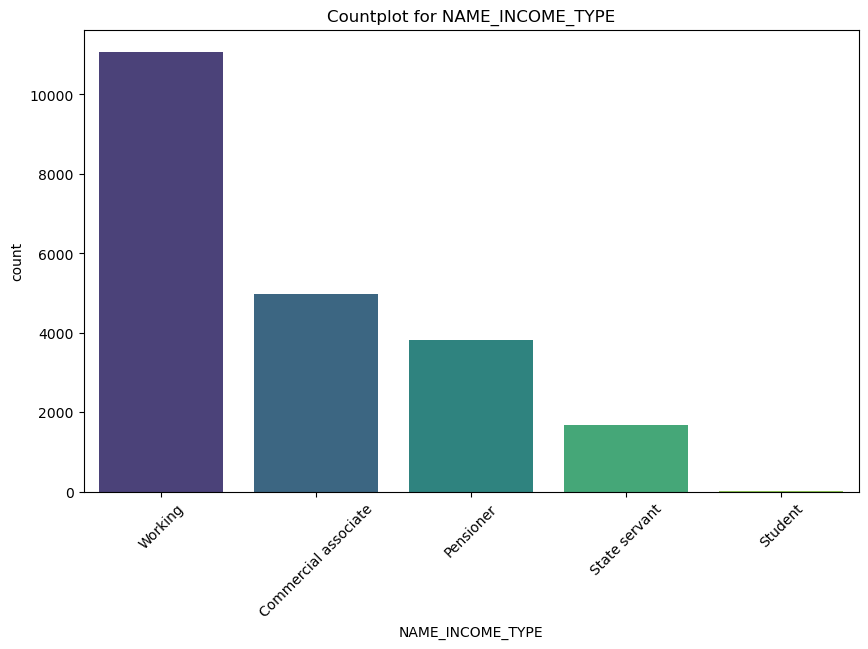

Analysis for column: NAME_EDUCATION_TYPE
Number of unique values: 5
Unique values are: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Value counts:
NAME_EDUCATION_TYPE
Secondary / secondary special    14725
Higher education                  5783
Incomplete higher                  808
Lower secondary                    216
Academic degree                     21
Name: count, dtype: int64


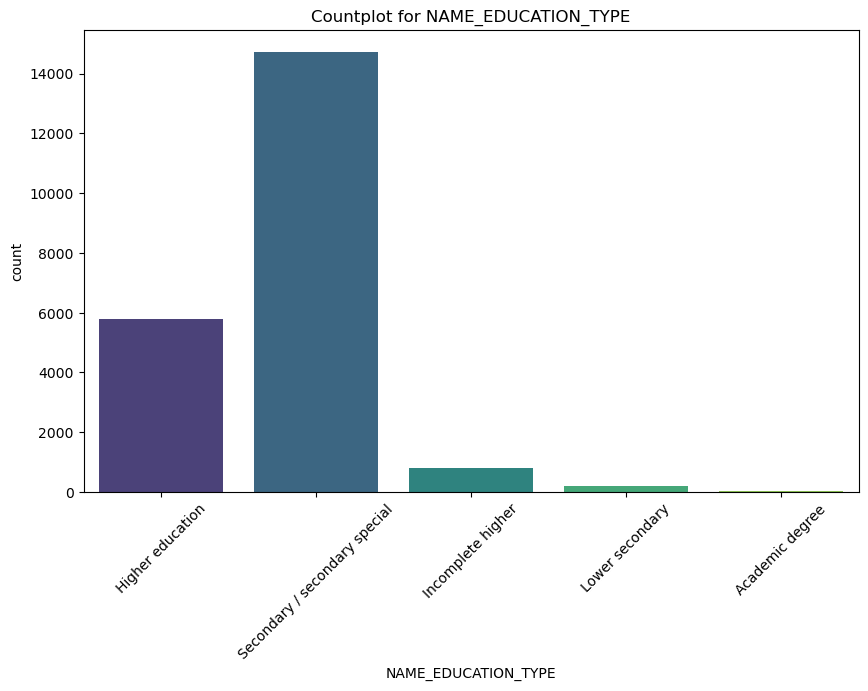

Analysis for column: NAME_FAMILY_STATUS
Number of unique values: 5
Unique values are: ['Civil marriage' 'Single / not married' 'Separated' 'Married' 'Widow']
Value counts:
NAME_FAMILY_STATUS
Married                 14699
Single / not married     2806
Civil marriage           1768
Separated                1273
Widow                    1007
Name: count, dtype: int64


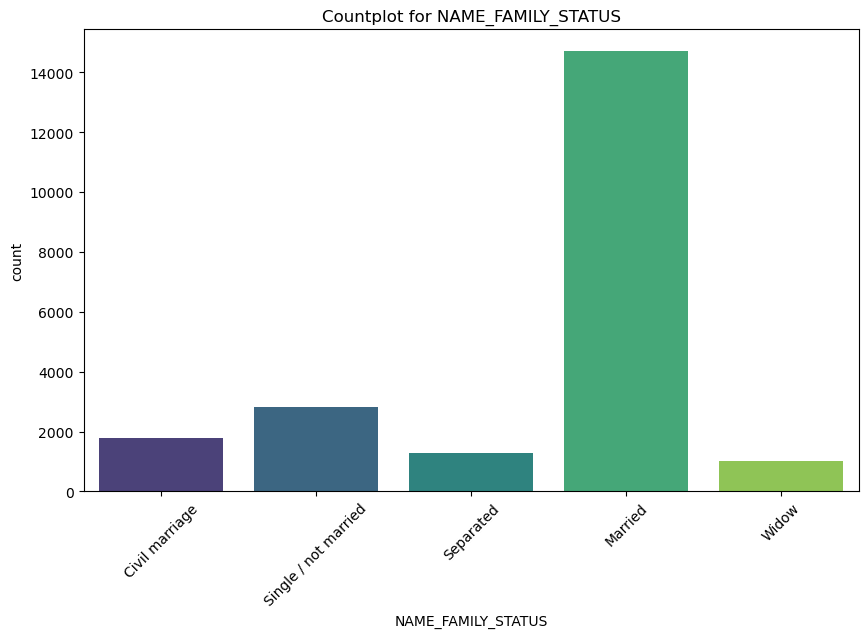

Analysis for column: NAME_HOUSING_TYPE
Number of unique values: 6
Unique values are: ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
Value counts:
NAME_HOUSING_TYPE
House / apartment      19378
With parents             978
Municipal apartment      632
Rented apartment         359
Office apartment         137
Co-op apartment           69
Name: count, dtype: int64


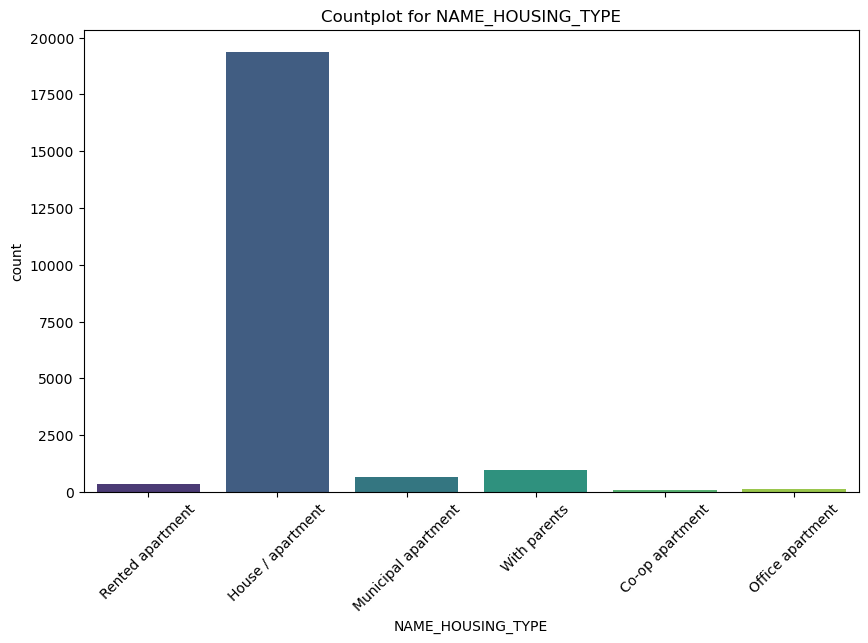

In [66]:
for col in cat_col:
    categorical_columns_analysis(merged_df, col, plot=True)

In [67]:
# Convert categorical features to dummy/indicator variables
merged_df = pd.get_dummies(merged_df,
                           columns=['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'],
                           drop_first=True)

In [70]:
bool_columns = merged_df.select_dtypes(include=['bool']).columns
merged_df[bool_columns] = merged_df[bool_columns].astype(int)

In [71]:
# Drop unnecessary columns
merged_df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

In [72]:
# Display the final DataFrame information
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21553 entries, 0 to 21552
Data columns (total 52 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 21553 non-null  int64  
 1   CODE_GENDER                                        21553 non-null  int32  
 2   FLAG_OWN_CAR                                       21553 non-null  int32  
 3   FLAG_OWN_REALTY                                    21553 non-null  int32  
 4   CNT_CHILDREN                                       21550 non-null  float64
 5   AMT_INCOME_TOTAL                                   21553 non-null  float64
 6   FLAG_MOBIL                                         21553 non-null  int64  
 7   FLAG_WORK_PHONE                                    21553 non-null  int64  
 8   FLAG_PHONE                                         21553 non-null  int64  
 9   FLAG_E

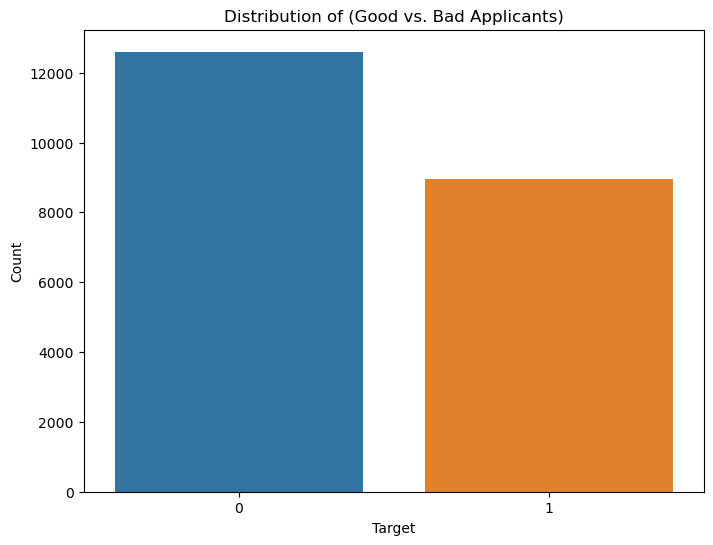

In [73]:
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=merged_df)
plt.title('Distribution of (Good vs. Bad Applicants)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

C:\Users\msi\anaconda3\anaconda3_main\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


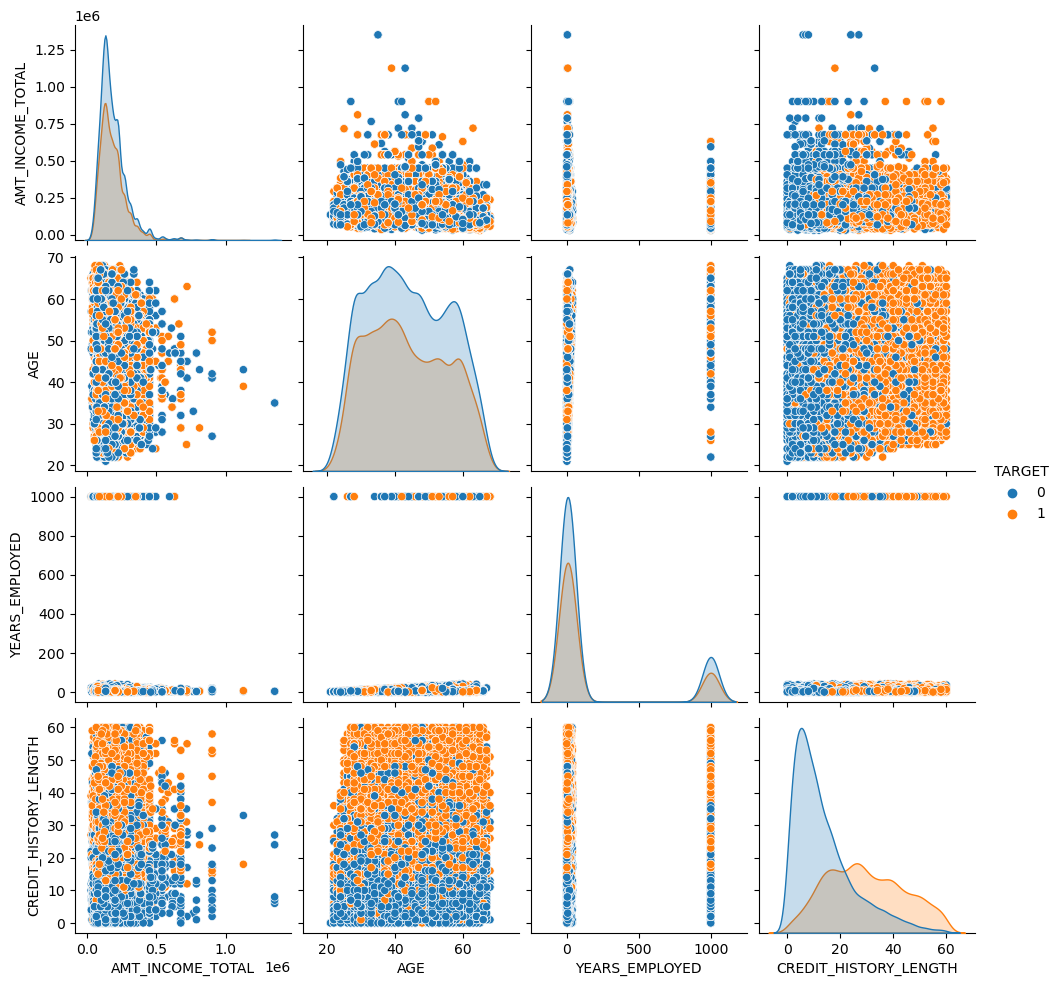

In [74]:
# Replace infinite values with NaN
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Pair Plot for numerical features
sns.pairplot(merged_df[['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED', 'CREDIT_HISTORY_LENGTH', 'TARGET']],
             hue='TARGET')
plt.show()

In [88]:
# Replace infinite values with NaN
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(inplace=True)

X = merged_df.drop(columns=['ID', 'TARGET'])
y = merged_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [90]:
# Logistic Regression 
logreg = LogisticRegression(max_iter=1000)  

logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)
print("Logistic Regression Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Logistic Regression Results:
Confusion Matrix:
 [[3171  651]
 [1074 1569]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79      3822
           1       0.71      0.59      0.65      2643

    accuracy                           0.73      6465
   macro avg       0.73      0.71      0.72      6465
weighted avg       0.73      0.73      0.73      6465

Accuracy Score:  0.7331786542923434
ROC AUC Score: 0.7116569582517368
